In [17]:
import scipy.sparse
import pandas
import itertools
import string
import random
import timeit
import numpy
import collections
pandas.__version__

'0.17.1'

In [253]:
m = 100
n = 50
A = scipy.sparse.rand(m, n, density=0.1, dtype=np.float32)

def getlab(m):
    i = range(int(ceil(sqrt(m))))
    ilab = permutation(list(itertools.product(i, i)))[:m]
    return ilab

ilab = getlab(m)
jlab = getlab(n)

df = pd.DataFrame(A.todense())
df.index = pd.MultiIndex.from_arrays(ilab.T)
df.columns = pd.MultiIndex.from_arrays(jlab.T)
s = df.stack([0, 1])
ilevels = [0, 1]
jlevels = [2, 3]

In [263]:
df = df.sort_index().sort_index(axis=1)
df.head().T.head().T

0                   
     0  1  2  3         4
0 0  0  0  0  0  0.000000
  1  0  0  0  0  0.000000
  2  0  0  0  0  0.000000
  3  0  0  0  0  0.252879
  4  0  0  0  0  0.000000

In [264]:
s.head()

5  7  0  0    0
         1    0
         2    0
         3    0
         4    0
dtype: float64

In [272]:
%%time
def get_sub_ind(ind, levels):
    ind = list(zip(*[s.index.labels[s.index._get_level_number(k)] for k in ilevels]))
    indmap = dict(((k, i) for i, k in enumerate(set(ind))))
    invmap = dict((i, k) for k, i in indmap.items())
    ind = [indmap[k] for k in ind]
    return ind, indmap, invmap

indi, indimap, invimap = get_sub_ind(s.index, ilevels)
indj, indjmap, invjmap = get_sub_ind(s.index, jlevels)

CPU times: user 15.4 ms, sys: 182 µs, total: 15.6 ms
Wall time: 15.6 ms


In [280]:
%%time
# requires named levels
def get_sub_ind(ind, levels):
    todrop = [x for x in range(s.index.nlevels) if x not in levels]
    ind = ind.droplevel(todrop)
    indmap = dict(((k, i) for i, k in enumerate(ind.unique())))
    ind = ind.to_series().map(indmap)
    return ind, indmap
indi, indimap = get_sub_ind(s.index, ilevels)
indj, indjmap = get_sub_ind(s.index, jlevels)

AA = scipy.sparse.csr_matrix((s.values, (indi.values, indj.values)), shape=(len(indimap), len(indjmap)), dtype=np.float32)
AA = pd.DataFrame(AA.todense())

CPU times: user 16.3 ms, sys: 1.56 ms, total: 17.9 ms
Wall time: 16.8 ms


In [283]:
indi

5  7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
   7     0
        ..
8  1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
   1    99
dtype: int64

In [282]:
AA.head().T.head().T

,0,1,2,3,4
0,0,0,0,0.000000,0.000000
1,0,0,0,0.958557,0.301996
2,0,0,0,0.000000,0.000000
3,0,0,0,0.000000,0.000000
4,0,0,0,0.000000,0.000000


In [273]:
%%time
ss = s.unstack(jlevels)
ss.head().T.head().T

CPU times: user 7.61 ms, sys: 1.48 ms, total: 9.08 ms
Wall time: 7.81 ms


In [162]:
s, ilevels, jlevels = make_example(n_levels=4, n_per_level=20)
s.shape, s.count(), float(s.count()) / s.shape[0], ilevels, jlevels

((160000,), 48028, 0.300175, ('a', 'b'), ('c', 'd'))

In [163]:
s = s.dropna()
s.shape, s.count(), float(s.count()) / s.shape[0], ilevels, jlevels

((48028,), 48028, 1.0, ('a', 'b'), ('c', 'd'))

In [164]:
s.head()

a    b    c    d  
SOB  ZZF  BG0  2GU    0.250431
               LT7    0.103961
               1YS    0.106960
               E9W    0.246636
               MQI    0.009110
Name: value, dtype: float64

In [165]:
%%time
def get_sub_ind(ind, levels):
    ind = list(zip(*[s.index.labels[s.index._get_level_number(k)] for k in ilevels]))
    indmap = dict(((k, i) for i, k in enumerate(set(ind))))
    ind = {k: indmap[k] for k in ind}
    return ind, indmap

indi, indimap = get_sub_ind(s.index, ilevels)
indj, indjmap = get_sub_ind(s.index, jlevels)

CPU times: user 132 ms, sys: 3.61 ms, total: 136 ms
Wall time: 137 ms


In [166]:
%%time
# requires named levels
def get_sub_ind(ind, levels):
    todrop = [x for x in s.index.names if x not in levels]
    ind = ind.droplevel(todrop)
    indmap = dict(((k, i) for i, k in enumerate(ind.unique())))
    ind = ind.to_series().map(indmap)
    return ind, indmap
indi, indimap = get_sub_ind(s.index, ilevels)
indj, indjmap = get_sub_ind(s.index, jlevels)

CPU times: user 122 ms, sys: 5.02 ms, total: 127 ms
Wall time: 127 ms


In [167]:
i = indi.values
j = indj.values
v = s.values
m = len(indimap)
n = len(indjmap)

A = scipy.sparse.csr_matrix((v, (i, j)), shape=(m, n), dtype=np.float32)
A.shape

(400, 400)

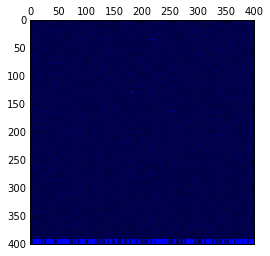

In [168]:
%matplotlib inline
spy(A)

In [170]:
A.todense()

matrix([[ 0.25043052,  0.10396126,  0.10696033, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.23306146,  0.15083176,  0.01067965, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.10937067,  0.11709633, ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.04343203,  0.        , ...,  0.15822434,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.22234783, ...,  0.18271866,
          0.22640456,  0.        ],
        [ 0.05036829,  0.        ,  0.        , ...,  0.        ,
          0.28968608,  0.        ]], dtype=float32)